# First Look at AuxTel Data
Originally written by Alex Broughton

In [1]:
! eups list -s | grep lsst_distrib
! eups list -s | grep cp_pipe
! eups list -s | grep ip_isr

lsst_distrib          g4213664e8e+c056df7596 	current w_2023_50 setup
cp_pipe               ga9e592dc03+3c94dbfbcc 	current w_2023_50 setup
ip_isr                ged8ae655b3+37e0927acf 	current w_2023_50 setup


In this notebook, we will explore how to use the data butler to access sky data from the LATISS instrument on AuxTel. As an example, we will fit the dependence of BF effect on color using on-sky data. We will learn how to access, reduce, and model the data using the data Butler attatched to USDF's $\texttt{/repo/embargo}$. The data is based on AuxTel data from the night of 2023-08-03/17/29.

You can find the most recent data here:
$\texttt{https://roundtable.lsst.codes/rubintv/summit/auxtel/historical/2023-08-03}$




In [2]:
# Generic bunch of imports (not all of these are needed)
import os
import numpy as np
import glob
from astropy.io import fits
import pandas as pd
import pickle as pkl
import galsim
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
from lsst.obs.lsst import Latiss
camera = Latiss().getCamera()
from matplotlib.pyplot import cm
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker
from tqdm import tqdm



##### First, I'll setup the space and define some utility functions that will be useful down the line.

In [3]:
pixscale = 0.0956783 # arcsec/pixel

def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

def getAstropyWcs(image, verbose=False):
    """
    Get an astropy WCS object from an lsst.afw.image metadata WCS format
    
    NOTE: Astropy WCS is not accurate enough for astrometry, use FITS standard
    Although, this is good enough for this notebook.
    
    Parameters
    ----------
    image: lsst.afw.image._exposure.ExposureF
        Input image with Fits Stadard WCS metadata

    Returns
    -------
    wcs: astropy.wcs.wcs.WCS
        Astropy WCS for the image object.
    """
    
    from astropy.wcs import WCS

    if verbose:
        print(image.getWcs())
    
    wcs_dict = dict()
    for val in image.getWcs().getFitsMetadata():
        wcs_dict[str(val)] = image.getWcs().getFitsMetadata()[str(val)]

    return WCS(wcs_dict)


def get2ndMomFromHsmResult(results):
    """
    Calculate second moments from HSM adative moment result
    derived by galsim HSM module (ShapeData object). 
    """
    e1 = results.observed_shape.e1
    e2 = results.observed_shape.e2
    sigma = results.moments_sigma
    sigma_ave = sigma / (1 - e1**2 - e2**2 )**(0.25) 
    Ixx = (1+e1) * sigma_ave**2
    Iyy = (1-e1) * sigma_ave**2
    Ixy = e2 * (sigma_ave**2) 
    
    return Ixx, Iyy, Ixy


    
def getStars(data, img):
    image = img.getImage().getArray()
    results = np.full((len(data), 10), np.nan)
    for i in range(len(data)):
        star = data.iloc[i]
        result = np.full((1, 12), np.nan)

        y = star['base_SdssCentroid_x']
        x = star['base_SdssCentroid_y']

        s = int(70/2.)

        xmin = int(max(0,x-s))
        xmax = int(min(image.shape[0]-1, x+s+1))
        ymin = int(max(0,y-s))
        ymax = int(min(image.shape[1]-1, y+s+1))
        stamp = galsim.Image(image[xmin:xmax,ymin:ymax])

        try:
            res = galsim.hsm.FindAdaptiveMom(stamp)
            ixx,iyy,ixy = get2ndMomFromHsmResult(res)
            result = [ixx,iyy,ixy,np.max(image[xmin:xmax,ymin:ymax]),res.moments_sigma,res.moments_amp,x,y,res.observed_shape.e1,res.observed_shape.e2]
        except:
            continue
        
        results[i] = result
        
    return results

def getStarStampMax(data, img):
    image = img.getImage().getArray()
    results = []
    for i in range(len(data)):
        star = data.iloc[i]

        y = star['x']
        x = star['y']

        s = int(70/2.)

        xmin = int(max(0,x-s))
        xmax = int(min(image.shape[0]-1, x+s+1))
        ymin = int(max(0,y-s))
        ymax = int(min(image.shape[1]-1, y+s+1))
        stamp = galsim.Image(image[xmin:xmax,ymin:ymax])
        results.append(np.max(image[xmin:xmax,ymin:ymax]))
        
    return results
    
def writeNumpy2Parquet(data, filename, colnames):
    data = data[~np.isnan(data).any(axis=1)]
    
    data_dict = dict()
    for i,col in enumerate(colnames):
        data_dict[colnames[i]] = data[:,i]

    pd.DataFrame.from_dict(data_dict).to_parquet(filename, compression='gzip') 


First we are going to setup a butler to repository where the LATISS data is ingested on USDF ($\texttt{/repo/embargo}$). It normally takes 1-2 days after data is taken for it to be accessible from a butler repository.

You can process your own raw data into collections, or you can look at the Data Reduction Pipeline (DRP) processed images which should already be available to you. The DRP collections contain fully caliobrated images and tables of objects using the most up-to-date calibrations, and we will use those here.

Let's query all the collections that were processed with the most recent weekly release of the LSST Science Pipelines (w_2023_33):

In [4]:
repo = "/repo/embargo"
butler = Butler(repo)
registry = butler.registry

collections = []
for c in registry.queryCollections("LATISS/runs/AUXTEL_DRP_IMAGING*2023*"):
    collections.append(c)
    print(c) 

LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20231207/w_2023_49/PREOPS-4648/20231208T201052Z
LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20231207/w_2023_49/PREOPS-4648/20231208T204909Z
LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20231207/w_2023_49/PREOPS-4648/20231211T231648Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-01A/w_2023_03/PREOPS-3194/20230124T175418Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-01B/w_2023_05/PREOPS-3230/default/20230207T170447Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-01B/w_2023_05/PREOPS-3230/default/20230208T153113Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-01B/w_2023_05/PREOPS-3230/parallel_DM-37811/20230208T185747Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-01B/w_2023_05/PREOPS-3230/default/20230208T175614Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-01B/w_2023_05/PREOPS-3230/parallel_DM-37811/20230209T165855Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-01B/w_2023_05/PREOPS-3230/default_2/20230209T214707Z
LATISS/runs/AUXTEL_DRP_IMAGING_2023-01B/w_2023_05/PREOPS-3230/parallel_DM-37811/20230209T215639Z
LATISS/runs/AUXT

Not all of these collections have finalized_src_tables, and some of them are reprocessings with different versions of DM Stack.

In [6]:
these_collections = []
# for col in tqdm(these_collections):
#     subbutler = Butler(repo,collections=col)
#     subregistry = subbutler.registry
#     try:
#         refs = np.sort(list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=col, where="band IN ('i','r','g') AND visit>=2023080300000")))
#         if len(refs) > 0:
#             these_collections.append(col)
#     except:
#         continue

In [7]:
these_collections

[]

These are the collections that have the finalized tables in them. And there are only 3 unique collections with recent processings. We will use those.

In [8]:
these_collections = "u/laurenma/DM-40955_LATISS_PSF"

Let's grab a smaller butler which contains a registry of data within just these collections. We will find all exposures that were imaged on or after 8/3/2023 in the SDSS i band and have an associated table of calibrated stars.
<br> The $\texttt{finalized_src_table}$ data type will contain a catalog of calibrated stars. 



In [9]:
subbutler = Butler(repo,collections=these_collections)
subregistry = subbutler.registry
refs = np.sort(list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=these_collections, where="band='i' AND visit>=2023050100000")))

print(len(refs))

597


We now have a list of references which match specific images (visits in this case) and all their accompanying data products.

You can get any of the data types listed in the DRP pipeline associated with these visits. 

If you want the processed image, you can query postISRCCD or calexp. 
$\texttt{postISRCCD}$ is an image that has been run through ISR but has not been calibrated astrometrically or photometrically or with a PSF model.
It is a temporary intermediate object that will not be part of a release. In the future, $\texttt{calexps}$ will be called $\texttt{pvis}$, or “processed visit images”.
These will have final-final calibrations applied (the calexp has early calibrations). To get $\texttt{calexps}$, you must also pass the detector argument (there is only one sensor on AuxTel and its detector number is 0). If you want a $\texttt{postISRCCD}$, you will also need to supply an exposure number, which in this case is the same as the visit number since we are only taking one exposure/vist.

## Example Image:

In [10]:
refs[500].dataId

{instrument: 'LATISS', visit: 2023080300734, band: 'i', physical_filter: 'SDSSi_65mm~empty'}

In [11]:
stars = subbutler.get('sourceTable_visit', dataId = refs[0].dataId, collections=these_collections)
print(stars.columns)

Index(['coord_ra', 'coord_dec', 'ccdVisitId', 'parentSourceId', 'x', 'y',
       'xErr', 'yErr', 'ra', 'dec',
       ...
       'hsmShapeRegauss_flag_galsim', 'hsmShapeRegauss_flag_no_pixels',
       'hsmShapeRegauss_flag_not_contained',
       'hsmShapeRegauss_flag_parent_source', 'sky_source', 'detect_isPrimary',
       'visit', 'detector', 'band', 'physical_filter'],
      dtype='object', length=160)


In [12]:
image = subbutler.get('calexp', dataId = refs[0].dataId, detector=0,collections=these_collections)

# Optionally, 
# print(image.getMetadata())

<frozen _collections_abc>:860: FutureWarning: Call to deprecated method __iter__. (Using DataCoordinate as a Mapping is deprecated in favor of the .mapping and .required attributes, and will be dropped after v27.) -- Deprecated since version v27.
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/daf_butler/g40b9058a42+e5d7208b6c/python/lsst/daf/butler/dimensions/_coordinate.py:535: FutureWarning: Call to deprecated method keys. (Using DataCoordinate as a Mapping is deprecated in favor of the .mapping and .required attributes, and will be dropped after v27.) -- Deprecated since version v27.
  return iter(self.keys())
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/daf_butler/g40b9058a42+e5d7208b6c/python/lsst/daf/butler/dimensions/_coordinate.py:555: FutureWarning: Call to deprecated function (or staticmethod) graph. (DataCoordinate.graph is deprecated in favor of .dimensions, and will be dropped after v27.) -- Deprecated since version v27.
  return s

In [13]:
# Optinally,
# collections = these_collections
# #collections = 'u/echarles/calib/bias/run_12781/20210326T180033Z'
# subbutler = Butler(repo,collections=collections)
# subregistry = subbutler.registry
# for dtype in subregistry.queryDatasetTypes():
#     try:
#         datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
#         print(len(datasetRefs), dtype )
#     except:
#         print("Error", dtype )

First look at AuxTel image:

In [14]:
stars.columns

Index(['coord_ra', 'coord_dec', 'ccdVisitId', 'parentSourceId', 'x', 'y',
       'xErr', 'yErr', 'ra', 'dec',
       ...
       'hsmShapeRegauss_flag_galsim', 'hsmShapeRegauss_flag_no_pixels',
       'hsmShapeRegauss_flag_not_contained',
       'hsmShapeRegauss_flag_parent_source', 'sky_source', 'detect_isPrimary',
       'visit', 'detector', 'band', 'physical_filter'],
      dtype='object', length=160)

In [15]:
np.count_nonzero(stars['pixelFlags_edge'] & stars['calib_psf_used'])

0

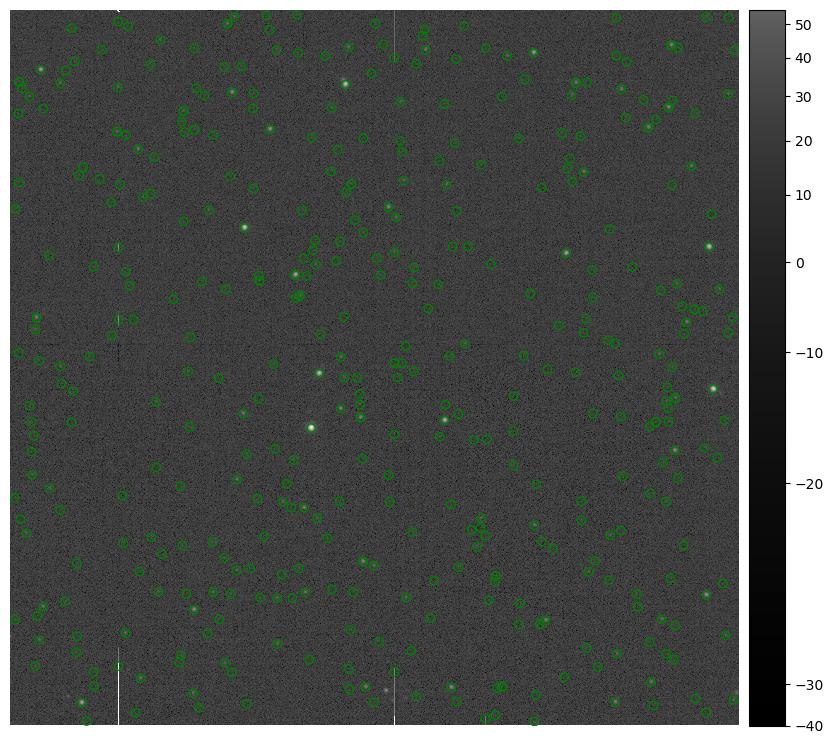

In [16]:
display(image)
#plt.scatter(stars['x'],stars['y'], marker="o", color="blue", facecolor="None")
brightest = np.sort(stars['psfFlux'])[-4]
#plt.scatter(stars['x'][stars['psfFlux'] == brightest], stars['y'][stars['psfFlux'] == brightest], marker="o", color="red", facecolor="None")
plt.scatter(stars['x'], stars['y'], marker="o", color="green", facecolor="None")



In [17]:
# for c in stars.columns:
#     print(c)

In [18]:
good_dict = \
{'blendedness_flag': False,
 'blendedness_flag_noCentroid': False,
 'blendedness_flag_noShape': False,
 'extendedness_flag': False,
 'jacobian_flag': False,
 'localBackground_flag': False,
 'localBackground_flag_noGoodPixels': False,
 'localBackground_flag_noPsf': False,
 #'pixelFlags_bad': False,
 'pixelFlags_cr': False,
 'pixelFlags_crCenter': False,
 #'pixelFlags_edge': False,
 'pixelFlags_interpolated': False,
 'pixelFlags_interpolatedCenter': False,
 'pixelFlags_offimage': False,
 'pixelFlags_saturated': False,
 'pixelFlags_saturatedCenter': False,
 'pixelFlags_suspect': False,
 'pixelFlags_suspectCenter': False,
 'psfFlux_flag': False,
 'psfFlux_flag_apCorr': False,
 'psfFlux_flag_edge': False,
 'psfFlux_flag_noGoodPixels': False,
 'gaussianFlux_flag': False,
 'centroid_flag_almostNoSecondDerivative': False,
 'centroid_flag_badError': False,
 #'centroid_flag_edge': False,
 'centroid_flag_noSecondDerivative': False,
 'centroid_flag_notAtMaximum': False,
 'centroid_flag_resetToPeak': False,
 # 'calib_astrometry_used': True,
 'calib_detected': True,
 # 'calib_photometry_reserved': False,
 # 'calib_photometry_used': True,
 # 'calib_psf_candidate': True,
 # 'calib_psf_reserved': False,
 # 'calib_psf_used': True,
 'variance_flag': True,
 'variance_flag_emptyFootprint': True,
 'deblend_hasStrayFlux': False,
 'deblend_masked': False,
 'deblend_parentTooBig': False,
 'deblend_patchedTemplate': False,
 'deblend_rampedTemplate': False,
 'deblend_skipped': False,
 'deblend_tooManyPeaks': False,
 'hsmPsfMoments_flag': False,
 'hsmPsfMoments_flag_no_pixels': False,
 'hsmPsfMoments_flag_not_contained': False,
 'hsmPsfMoments_flag_parent_source': False,
 'iDebiasedPSF_flag': False,
 'iDebiasedPSF_flag_no_pixels': False,
 'iDebiasedPSF_flag_not_contained': False,
 'iDebiasedPSF_flag_galsim': False,
 'iDebiasedPSF_flag_edge': False}

good = np.ones_like(stars['calib_psf_used'], dtype=bool)
for i, key in enumerate(good_dict.keys()):
    mask = (stars[key].to_numpy() == good_dict[key])
    if i == 0:
        good = mask
    good = np.logical_and(good,mask)
good = np.logical_or(good,stars['calib_psf_used'])

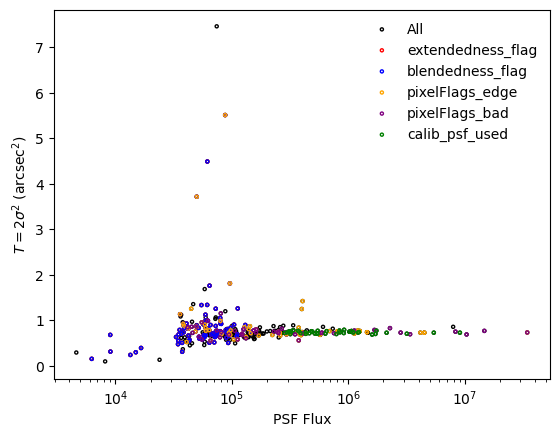

In [19]:

psf_stars = (stars['calib_psf_used'] == True)
psf_extended = (stars['extendedness_flag'] == True)
psf_blended = (stars["blendedness_flag"])
psf_edge = (stars['pixelFlags_edge'])
psf_badpix = (stars['pixelFlags_bad'])

T = (stars['ixx'] + stars['iyy']) * pixscale**2

plt.scatter(stars['psfFlux'], T, color="k", marker="o",facecolor="None",s=5, label="All")
plt.scatter(stars['psfFlux'][psf_extended], T[psf_extended], color="red", marker="o",facecolor="None",s=5, label="extendedness_flag")
plt.scatter(stars['psfFlux'][psf_blended], T[psf_blended], color="blue", marker="o",facecolor="None",s=5, label="blendedness_flag")
plt.scatter(stars['psfFlux'][psf_edge], T[psf_edge], color="orange", marker="o",facecolor="None",s=5, label="pixelFlags_edge")
plt.scatter(stars['psfFlux'][psf_badpix], T[psf_badpix], color="purple", marker="o",facecolor="None",s=5, label="pixelFlags_bad")
plt.scatter(stars['psfFlux'][psf_stars], T[psf_stars], color="green", marker="o",facecolor="None",s=5, label="calib_psf_used")

plt.ylabel("$T = 2\sigma^{2}$" + " (arcsec$^{2}$)")
plt.xlabel("PSF Flux")
plt.xscale('log')
plt.legend(frameon=False)

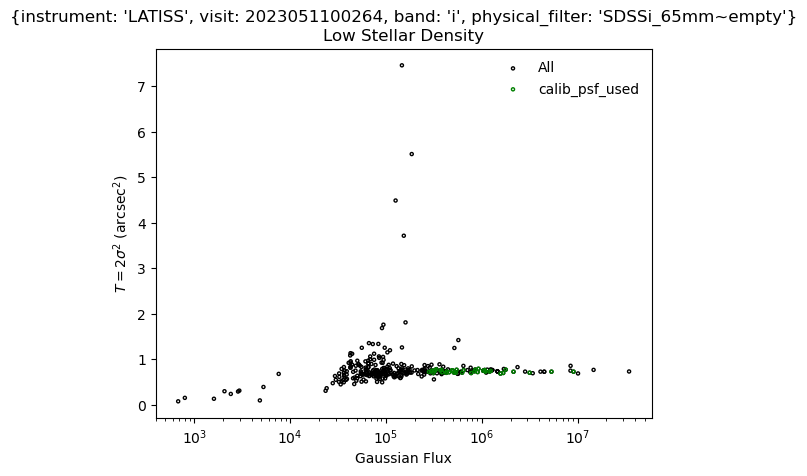

In [20]:
psf_stars = (stars['calib_psf_used'] == True)
psf_extended = (stars['extendedness_flag'] == True)
psf_blended = (stars["blendedness_flag"])
psf_edge = (stars['pixelFlags_edge'])
psf_badpix = (stars['pixelFlags_bad'])


psf_used = (stars['calib_psf_used'])
new = good & ~psf_used
suspect = (~good * stars['calib_psf_used'])

T = (stars['ixx'] + stars['iyy']) * pixscale**2

plt.scatter(stars['gaussianFlux'], T, color="k", marker="o",facecolor="None",s=5, label="All")
plt.scatter(stars['gaussianFlux'][psf_used], T[psf_used], color="green", marker="o",facecolor="None",s=5, label="calib_psf_used")
#plt.scatter(stars['gaussianFlux'][new], T[new], color="blue", marker="o",facecolor="None",s=5, label="good & ~calib_psf_used")

#plt.scatter(stars['gaussianFlux'][suspect], T[suspect], color="red", marker="o",facecolor="None",s=5, label="~good & calib_psf_used")

plt.ylabel("$T = 2\sigma^{2}$" + " (arcsec$^{2}$)")
plt.xlabel("Gaussian Flux")
plt.xscale('log')
plt.title(f"{refs[0].dataId}\nLow Stellar Density")
plt.legend(frameon=False)

In [21]:
sourceTable_visit = subbutler.get('sourceTable_visit', dataId = refs[0].dataId, collections=these_collections)
finalized_src_table = subbutler.get('finalized_src_table', dataId = refs[0].dataId, collections=these_collections)



In [22]:
sourceIds = []
for i in range(len(sourceTable_visit)):
    sourceIds.append(sourceTable_visit.iloc[i].name)
sourceIds = np.asarray(sourceIds)

In [23]:
common = np.intersect1d(sourceIds,finalized_src_table['id'])

## Get the number of stars/exposure (the inefficient way)

In [24]:
%%time
refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=these_collections, where="band='i' AND visit>=2023050000000")) 
data_list_i = []
for ref in tqdm(refs):
    data = subbutler.get('finalized_src_table', dataId = ref.dataId, collections=these_collections)
    data_list_i.append(len(data[data['calib_psf_used']]))

refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=these_collections, where="band='r' AND visit>=2023050000000")) 
data_list_r = []
for ref in tqdm(refs):
    data = subbutler.get('finalized_src_table', dataId = ref.dataId, collections=these_collections)
    data_list_r.append(len(data[data['calib_psf_used']]))

refs = list(subregistry.queryDatasets(datasetType='finalized_src_table', collections=these_collections, where="band='g' AND visit>=2023050000000")) 
data_list_g = []
for ref in tqdm(refs):
    data = subbutler.get('finalized_src_table', dataId = ref.dataId, collections=these_collections)
    data_list_g.append(len(data[data['calib_psf_used']]))

100%|██████████| 576/576 [01:06<00:00,  8.68it/s]

CPU times: user 1min 26s, sys: 4.89 s, total: 1min 31s
Wall time: 3min 26s


31290 39977 24064


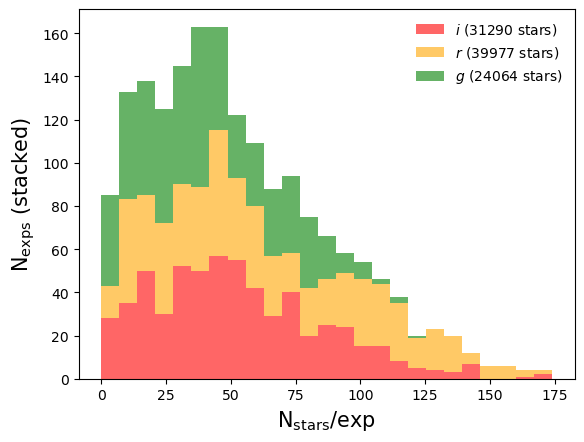

In [25]:
plt.figure()
_ = plt.hist([data_list_i,data_list_r,data_list_g], stacked=True, bins=25, color=['r','orange','g'], label=[f'$i$ ({np.sum(data_list_i)} stars)',f'$r$ ({np.sum(data_list_r)} stars)',f'$g$ ({np.sum(data_list_g)} stars)'], alpha=0.6)
plt.ylabel("$\mathrm{N_{exps}}$ (stacked)", fontsize=15)
plt.xlabel("$\mathrm{N_{stars}}$/exp", fontsize=15)
plt.legend(frameon=False)

print(np.sum(data_list_i), np.sum(data_list_r), np.sum(data_list_g))


In [26]:
np.sum(data_list_i), np.sum(data_list_r), np.sum(data_list_g)

(31290, 39977, 24064)

## Let's get the data from the g,r,and i bands. If you want add compute your own metrics/star, run this:

In [27]:
%%time

full_data_i = pd.DataFrame()
refs = list(subregistry.queryDatasets(datasetType='sourceTable_visit', collections=these_collections, where="band='i' AND visit>=2023050100000")) 
for ref in tqdm(refs):
    data = subbutler.get('sourceTable_visit', dataId = ref.dataId, collections=these_collections)
    image = subbutler.get('calexp', dataId = ref.dataId, detector=0, exposure=ref.dataId['visit'], collections=these_collections)
    fMaxs = getStarStampMax(data, image)
    
    mjds = [image.getMetadata()['MJD']]*len(data)
    visits = [ref.dataId['visit']]*len(data)
    
    data["MJD"] = mjds
    data["visit"] = visits
    data["fMax"] = fMaxs
    
    full_data_i = pd.concat([full_data_i, data])


  0%|          | 0/520 [00:00<?, ?it/s]<frozen _collections_abc>:860: FutureWarning: Call to deprecated method __iter__. (Using DataCoordinate as a Mapping is deprecated in favor of the .mapping and .required attributes, and will be dropped after v27.) -- Deprecated since version v27.
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/daf_butler/g40b9058a42+e5d7208b6c/python/lsst/daf/butler/dimensions/_coordinate.py:535: FutureWarning: Call to deprecated method keys. (Using DataCoordinate as a Mapping is deprecated in favor of the .mapping and .required attributes, and will be dropped after v27.) -- Deprecated since version v27.
  return iter(self.keys())
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/daf_butler/g40b9058a42+e5d7208b6c/python/lsst/daf/butler/dimensions/_coordinate.py:555: FutureWarning: Call to deprecated function (or staticmethod) graph. (DataCoordinate.graph is deprecated in favor of .dimensions, and will be dropped after v27.) -- D

CPU times: user 8min 41s, sys: 1min 35s, total: 10min 16s
Wall time: 11min 1s


In [30]:
%%time

full_data_r = pd.DataFrame()
refs = list(subregistry.queryDatasets(datasetType='sourceTable_visit', collections=these_collections, where="band='r' AND visit>=2023050100000")) 
for ref in tqdm(refs):
    data = subbutler.get('sourceTable_visit', dataId = ref.dataId, collections=these_collections)
    image = subbutler.get('calexp', dataId = ref.dataId, detector=0, exposure=ref.dataId['visit'], collections=these_collections)
    fMaxs = getStarStampMax(data, image)
    
    mjds = [image.getMetadata()['MJD']]*len(data)
    visits = [ref.dataId['visit']]*len(data)
    
    data["MJD"] = mjds
    data["visit"] = visits
    data["fMax"] = fMaxs
    
    full_data_r = pd.concat([full_data_r, data])


  0%|          | 0/547 [00:00<?, ?it/s]<frozen _collections_abc>:860: FutureWarning: Call to deprecated method __iter__. (Using DataCoordinate as a Mapping is deprecated in favor of the .mapping and .required attributes, and will be dropped after v27.) -- Deprecated since version v27.
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/daf_butler/g40b9058a42+e5d7208b6c/python/lsst/daf/butler/dimensions/_coordinate.py:535: FutureWarning: Call to deprecated method keys. (Using DataCoordinate as a Mapping is deprecated in favor of the .mapping and .required attributes, and will be dropped after v27.) -- Deprecated since version v27.
  return iter(self.keys())
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/daf_butler/g40b9058a42+e5d7208b6c/python/lsst/daf/butler/dimensions/_coordinate.py:555: FutureWarning: Call to deprecated function (or staticmethod) graph. (DataCoordinate.graph is deprecated in favor of .dimensions, and will be dropped after v27.) -- D

CPU times: user 8min 58s, sys: 1min 43s, total: 10min 41s
Wall time: 11min 20s


In [31]:
%%time

full_data_g = pd.DataFrame()
refs = list(subregistry.queryDatasets(datasetType='sourceTable_visit', collections=these_collections, where="band='g' AND visit>=2023050100000")) 
for ref in tqdm(refs):
    data = subbutler.get('sourceTable_visit', dataId = ref.dataId, collections=these_collections)
    image = subbutler.get('calexp', dataId = ref.dataId, detector=0, exposure=ref.dataId['visit'], collections=these_collections)
    fMaxs = getStarStampMax(data, image)
    
    mjds = [image.getMetadata()['MJD']]*len(data)
    visits = [ref.dataId['visit']]*len(data)
    
    data["MJD"] = mjds
    data["visit"] = visits
    data["fMax"] = fMaxs
    
    full_data_g = pd.concat([full_data_g, data])

  0%|          | 0/489 [00:00<?, ?it/s]<frozen _collections_abc>:860: FutureWarning: Call to deprecated method __iter__. (Using DataCoordinate as a Mapping is deprecated in favor of the .mapping and .required attributes, and will be dropped after v27.) -- Deprecated since version v27.
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/daf_butler/g40b9058a42+e5d7208b6c/python/lsst/daf/butler/dimensions/_coordinate.py:535: FutureWarning: Call to deprecated method keys. (Using DataCoordinate as a Mapping is deprecated in favor of the .mapping and .required attributes, and will be dropped after v27.) -- Deprecated since version v27.
  return iter(self.keys())
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-7.0.1/Linux64/daf_butler/g40b9058a42+e5d7208b6c/python/lsst/daf/butler/dimensions/_coordinate.py:555: FutureWarning: Call to deprecated function (or staticmethod) graph. (DataCoordinate.graph is deprecated in favor of .dimensions, and will be dropped after v27.) -- D

CPU times: user 7min 45s, sys: 1min 32s, total: 9min 17s
Wall time: 9min 49s


In [32]:
full_data_i.to_parquet(f"./df_stars_iband.parquet.gzip", compression='gzip') 
full_data_r.to_parquet(f"./df_stars_rband.parquet.gzip", compression='gzip') 
full_data_g.to_parquet(f"./df_stars_gband.parquet.gzip", compression='gzip') 

In [33]:
full_data_i = pd.read_parquet("./df_stars_iband.parquet.gzip") #.to_numpy()
full_data_r = pd.read_parquet("./df_stars_rband.parquet.gzip") #.to_numpy()
full_data_g = pd.read_parquet("./df_stars_gband.parquet.gzip") #.to_numpy()

Text(0.5, 0, 'N/bin')

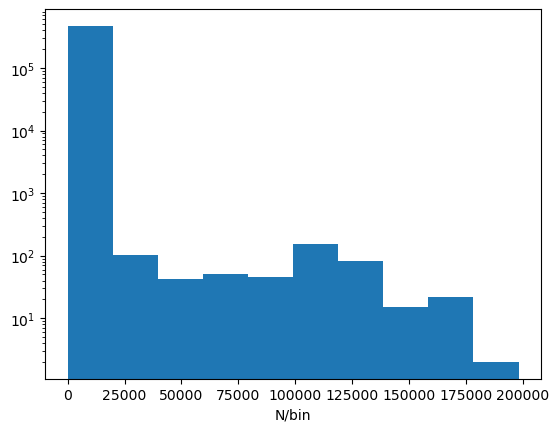

In [34]:
f = plt.hist(full_data_i['fMax'])
plt.semilogy()
plt.xlabel("$f_{max}$")
plt.xlabel("N/bin")

We now have a dataframe with a row for each star.

In [35]:
for c in full_data_i.columns:
    print(c) 

coord_ra
coord_dec
ccdVisitId
parentSourceId
x
y
xErr
yErr
ra
dec
decl
raErr
decErr
ra_dec_Cov
calibFlux
calibFluxErr
ap03Flux
ap03FluxErr
ap03Flux_flag
ap06Flux
ap06FluxErr
ap06Flux_flag
ap09Flux
ap09FluxErr
ap09Flux_flag
ap12Flux
ap12FluxErr
ap12Flux_flag
ap17Flux
ap17FluxErr
ap17Flux_flag
ap25Flux
ap25FluxErr
ap25Flux_flag
ap35Flux
ap35FluxErr
ap35Flux_flag
ap50Flux
ap50FluxErr
ap50Flux_flag
ap70Flux
ap70FluxErr
ap70Flux_flag
sky
skyErr
psfFlux
psfFluxErr
ixx
iyy
ixy
ixxPSF
iyyPSF
ixyPSF
ixxDebiasedPSF
iyyDebiasedPSF
ixyDebiasedPSF
gaussianFlux
gaussianFluxErr
extendedness
localPhotoCalib
localPhotoCalib_flag
localPhotoCalibErr
localWcs_flag
localWcs_CDMatrix_2_1
localWcs_CDMatrix_1_1
localWcs_CDMatrix_1_2
localWcs_CDMatrix_2_2
blendedness_abs
blendedness_flag
blendedness_flag_noCentroid
blendedness_flag_noShape
apFlux_12_0_flag
apFlux_12_0_flag_apertureTruncated
apFlux_12_0_flag_sincCoeffsTruncated
apFlux_12_0_instFlux
apFlux_12_0_instFluxErr
apFlux_17_0_flag
apFlux_17_0_instFlux
a

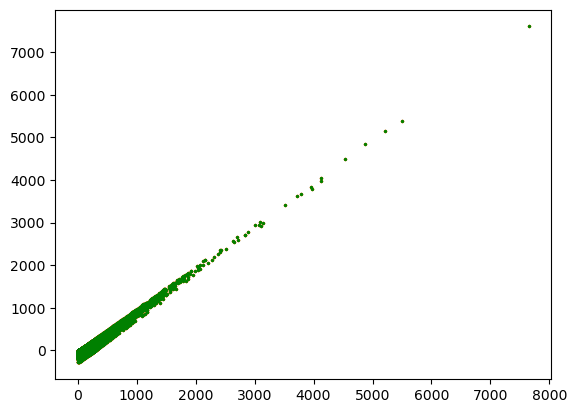

In [41]:
iT = full_data_i['ixx']+full_data_i['iyy']
iT_psf = full_data_i['ixxPSF']+full_data_i['iyyPSF']

rT = full_data_i['ixx']+full_data_i['iyy']
rT_psf = full_data_i['ixxPSF']+full_data_i['iyyPSF']

gT = full_data_i['ixx']+full_data_i['iyy']
gT_psf = full_data_i['ixxPSF']+full_data_i['iyyPSF']

plt.scatter(iT, iT-iT_psf,s=2,c="r")
plt.scatter(rT, rT-rT_psf,s=2,c="orange")
plt.scatter(gT, gT-gT_psf,s=2,c="g")
#plt.xlim(0,400)
#plt.ylim(-50,350)

# Seeing vs exposure

In [42]:
pixscale = 0.0956783 # arcsec/pixel


In [43]:
fwhm_i = np.sqrt(iT/2.) * pixscale
fwhm_r = np.sqrt(rT/2.) * pixscale
fwhm_g = np.sqrt(gT/2.) * pixscale



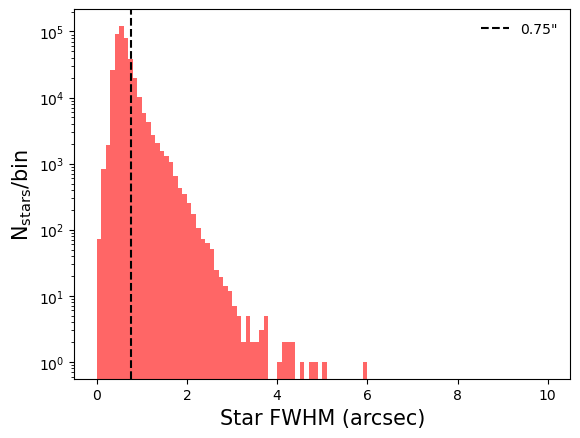

In [44]:
plt.figure()
_ = plt.hist(fwhm_i, stacked=True, bins=100,range=(0,10), color='r', alpha=0.6)
plt.ylabel("$\mathrm{N_{stars}}$/bin", fontsize=15)
plt.xlabel("Star FWHM (arcsec)", fontsize=15)
plt.axvline(0.75, linestyle="--", color="k", label="0.75\"")
plt.legend(frameon=False)
plt.yscale('log')


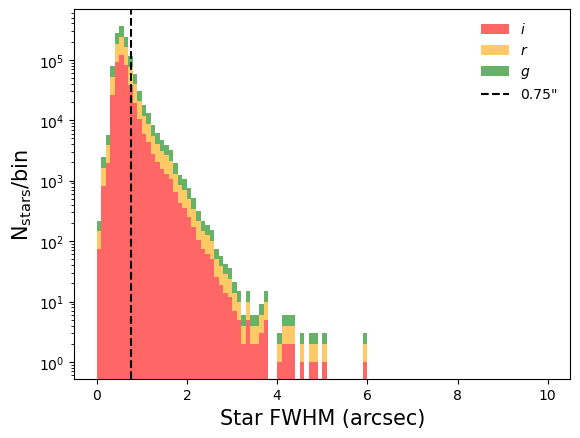

In [45]:
plt.figure()
_ = plt.hist([fwhm_i,fwhm_r,fwhm_g], stacked=True, bins=100,range=(0,10), color=['r','orange','g'], label=['$i$','$r$','$g$'], alpha=0.6)
plt.ylabel("$\mathrm{N_{stars}}$/bin", fontsize=15)
plt.xlabel("Star FWHM (arcsec)", fontsize=15)
plt.axvline(0.75, linestyle="--", color="k", label="0.75\"")
plt.legend(frameon=False)
plt.yscale('log')


In [46]:
MJDs_i = np.sort(np.unique(full_data_i["MJD"]))
seeings_i = []
for mjd in MJDs_i:
    try:
        seeings_i.append(np.mean(fwhm_i[full_data_i["MJD"]==mjd]))
    except:
        seeings_i.append(np.nan)
        
MJDs_r = np.sort(np.unique(full_data_r["MJD"]))
seeings_r = []
for mjd in MJDs_r:
    try:
        seeings_r.append(np.mean(fwhm_r[full_data_r["MJD"]==mjd]))
    except:
        seeings_r.append(np.nan)
        
        
MJDs_g = np.sort(np.unique(full_data_g["MJD"]))
seeings_g = []
for mjd in MJDs_g:
    try:
        seeings_g.append(np.mean(fwhm_g[full_data_g["MJD"]==mjd]))
    except:
        seeings_g.append(np.nan)

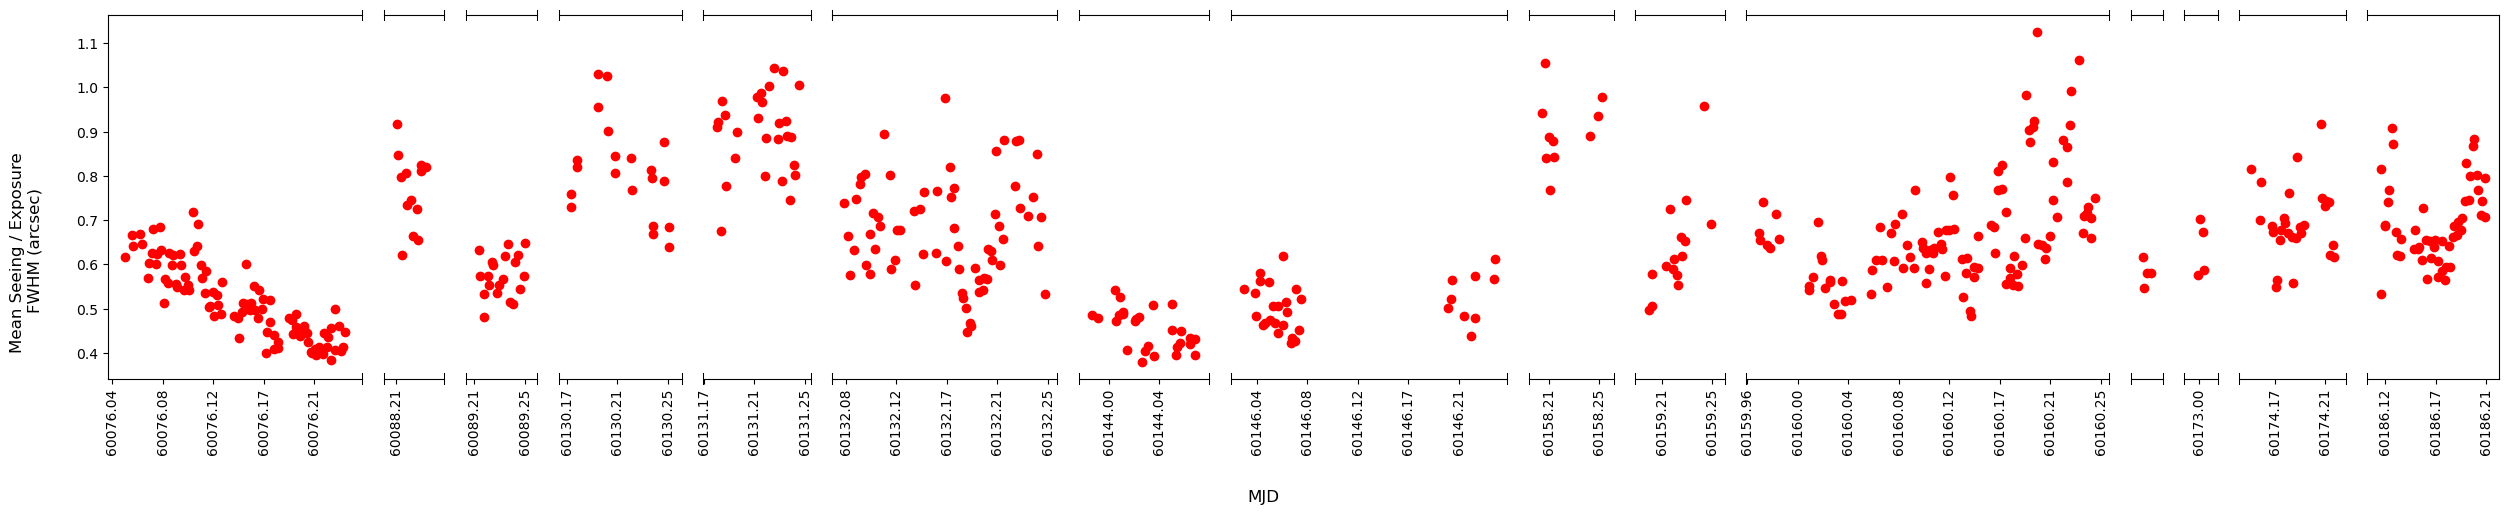

In [61]:
def getDataClusters(data, hspace=0):
    mi, ma = np.floor(np.min(data)), np.ceil(np.max(data))
    bins = np.histogram_bin_edges(data, bins=int(ma-mi))
    bin_idx = np.digitize(data, bins)
    clusters = []
    for i in range(int(ma-mi)):
        if len(bin_idx[bin_idx==i]) != 0:
            clusters.append((np.min(data[bin_idx==i]), np.max(data[bin_idx==i])))
    nclusters = len(clusters)
    clusters = [(clusters[i][0]-hspace, clusters[i][1]+hspace) for i in range(nclusters)]

    return clusters, nclusters

MJDs = np.concatenate((MJDs_r,MJDs_i,MJDs_g))
clusters, N = getDataClusters(MJDs, hspace=.01)

rel_bins = np.asarray([ma-mi for (mi,ma) in clusters])
rel_bins /= np.min(rel_bins)

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
fig, axs = plt.subplots(1,N, sharey=True, figsize=(25,5), gridspec_kw={'width_ratios': rel_bins})

for i in range(N):
    ax = axs[i]
    ax.scatter(MJDs_i, seeings_i, color="r")
    ax.scatter(MJDs_r, seeings_r, color="orange")
    ax.scatter(MJDs_g, seeings_g, color="g")
    ax.set_xlim(clusters[i][0],clusters[i][1])
    
    ax.set_xticks([clusters[i][0],clusters[i][1]],
               [clusters[i][0],clusters[i][1]], rotation=90)

    ax.xaxis.set_major_locator(MultipleLocator(1./24.))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    

for i, ax in enumerate(axs):

    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax.tick_params(labelright='off')
    ax.tick_params(labelleft='off')
    
    d = .015  # how big to make the diagonal lines in axes coordinates
    slope = 1/(rel_bins/np.sum(rel_bins))[i]
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', 
                  clip_on=False, linewidth=0.75)
    
    if i!=N-1:
        ax.plot((1, 1), (-d, d), **kwargs)
        ax.plot((1, 1), (1-d, 1+d), **kwargs)

    # switch to the bottom axes
    if i!=0:
        ax.plot((0, 0), (1-d, 1+d), **kwargs)
        ax.plot((0, 0), (-d, +d), **kwargs)
    if i==0:
        ax.spines['left'].set_visible(True)
        ax.get_yaxis().set_visible(True)
        ax.yaxis.tick_left()
        ax.tick_params(labelleft='on')
    if i==N-1:
        ax.spines['right'].set_visible(True)

#plt.ylim(0,8)

fig.supxlabel("MJD",y=-.01)
fig.supylabel("Mean Seeing / Exposure \nFWHM (arcsec)",x=0.005,horizontalalignment='center')
fig.tight_layout()

In [114]:
def common_mask(data):
    bad = (data > 0)
    return bad

In [115]:
from scipy.stats import binned_statistic_2d

## **Spatial PSF from 8 months of AuxTel data**

In [ ]:
bins_per_side = 150

range_xy = np.asarray([[0., 4096.], [0., 4000.]])
x = full_data_i["x"]
y = full_data_i["y"]
values = full_data_i["ixx"]+full_data_i["iyy"]

mask = (full_data_i["MJD"] > 0)

statistic, x_edge, y_edge, bin_number = binned_statistic_2d(x[mask],y[mask], 
                                                            values=values[mask], 
                                                            statistic=np.nanmedian, 
                                                            bins=[bins_per_side,bins_per_side])
from scipy.ndimage import gaussian_filter
#statistic=gaussian_filter(statistic, 1)

plt.imshow(statistic.T, origin='lower', interpolation='nearest',extent=[-200,200,-200,200], cmap='bwr')
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")
plt.title(r"$\left \langle T \right \rangle$")
plt.colorbar()

In [ ]:
bins_per_side = 100

range_xy = np.asarray([[0., 4096.], [0., 4000.]])
x = full_data_i["x"]
y = full_data_i["y"]
values = full_data_i["ixx"]+full_data_i["iyy"]

mask = (full_data_i["MJD"] > 0)

statistic, x_edge, y_edge, bin_number = binned_statistic_2d(x[mask],y[mask], 
                                                            values=values[mask], 
                                                            statistic="count", 
                                                            bins=[bins_per_side,bins_per_side])
from scipy.ndimage import gaussian_filter
statistic=gaussian_filter(statistic, 1)

plt.imshow(statistic.T, origin='lower', interpolation='nearest',extent=[-200,200,-200,200], cmap='bwr')
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")
plt.title("n/bin")
plt.colorbar()